**Модель предсказания оттока клиентов телекоммуникационной компании**


**Описание проекта:** Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.


**Цель исследования:** Анализ и обработка датасетов. Обучение модели бинарной классификации.

**Ход исследования:**
- загрузка и предоработка данных
- исследовательский анализ датафреймов
- объединеине датафреймов, более подробный анализ данных
- подготовка данных
- обучение моделей
- тестирование и анализ лучшей модели

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.


In [1]:
%pip install scikit-learn -q -U 
%pip install optuna-integration[sklearn] -q
%pip install phik -q
%pip install shap -q
%pip install catboost -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import phik
import shap

from functools import reduce

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder,
    LabelEncoder,
    MinMaxScaler,
    StandardScaler,
    RobustScaler
)

from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    roc_curve,
    confusion_matrix, 
    ConfusionMatrixDisplay
)

from optuna.integration import OptunaSearchCV
from optuna import distributions

#импортируем модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool


In [3]:
RANDOM_STATE = 28072025
TEST_SIZE = 0.25

In [4]:
warnings.filterwarnings('ignore')

## Загрузка данных и первичная обработка

In [5]:
df_contract = pd.read_csv(r'../datasets/contract_new.csv')
display(df_contract.head())
df_contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
df_personal = pd.read_csv(r'../datasets/personal_new.csv')
display(df_personal.head())
df_personal.info()                          

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [7]:
df_internet = pd.read_csv(r'../datasets/internet_new.csv')
display(df_internet.head())
df_internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [8]:
df_phone = pd.read_csv(r'../datasets/phone_new.csv')
display(df_phone.head())
df_phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В датафреймах присутсвуют числовые и сроковые данные, также данные, которые можно преобразовать в тип datetime и category. В самих датафреймах пропусков нет, но количество строк отличается. Из чего следует, что при объединении с помощью поля CustomerId будут пропуски

## Исследовательский анализ данных каждого датафрейма.

### DF_CONTRACT

In [9]:
for i in df_contract.drop(['customerID', 'BeginDate', 'MonthlyCharges', 'TotalCharges'], axis=1).columns:
    print(f'{i}: {df_contract[i].unique()}')

EndDate: ['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01' '2016-08-01'
 '2016-04-01' '2015-05-01' '2014-09-01' '2014-10-01' '2017-01-01'
 '2015-03-01' '2015-01-01' '2016-01-01' '2015-04-01' '2014-12-01'
 '2014-11-01']
Type: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 

В данном датасете мы обнаружили целевой признак, он находится в признаке EndDate, если стоит дата, то это означает, что сотрудник уволился. В разделе "Объединение датафреймов" добавим новую фичу - дней контракта. Чтобы добавить новую фичу, изменим значение "No" в признаке "EndDate" на дату выгрузки базы.

In [10]:
df_contract['Quit'] = df_contract['EndDate'].apply(lambda x: x if x == 'No' else 'Yes')
df_contract['EndDate'] = df_contract['EndDate'].apply(lambda x: x if x != 'No' else '2020-02-01')
df_contract['EndDate'].unique()

array(['2020-02-01', '2017-05-01', '2016-03-01', '2018-09-01',
       '2018-11-01', '2018-12-01', '2019-08-01', '2018-07-01',
       '2017-09-01', '2015-09-01', '2016-07-01', '2016-06-01',
       '2018-03-01', '2019-02-01', '2018-06-01', '2019-06-01',
       '2020-01-01', '2019-11-01', '2016-09-01', '2015-06-01',
       '2016-12-01', '2019-05-01', '2019-04-01', '2017-06-01',
       '2017-08-01', '2018-04-01', '2018-08-01', '2018-02-01',
       '2019-07-01', '2015-12-01', '2014-06-01', '2018-10-01',
       '2019-01-01', '2017-07-01', '2017-12-01', '2018-05-01',
       '2015-11-01', '2019-10-01', '2019-03-01', '2016-02-01',
       '2016-10-01', '2018-01-01', '2017-11-01', '2015-10-01',
       '2019-12-01', '2015-07-01', '2017-04-01', '2015-02-01',
       '2017-03-01', '2016-05-01', '2016-11-01', '2015-08-01',
       '2019-09-01', '2017-10-01', '2017-02-01', '2016-08-01',
       '2016-04-01', '2015-05-01', '2014-09-01', '2014-10-01',
       '2017-01-01', '2015-03-01', '2015-01-01', '2016-

In [11]:
display(df_contract.head())
df_contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,No
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Quit              7043 non-null   object 
dtypes: float64(1), object(8)
memory usage: 495.3+ KB


### DF_PERSONAL

In [12]:
df_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Для наглядности преобразуем 0 и 1 в No и Yes соотвественно

In [13]:
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [14]:
for i in df_personal.drop('customerID', axis=1).columns:
    print(f'{i}: {df_personal[i].unique()}')

gender: ['Female' 'Male']
SeniorCitizen: ['No' 'Yes']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']


### DF_INTERNET

In [15]:
for i in df_internet.drop('customerID', axis=1).columns:
    print(f'{i}: {df_internet[i].unique()}')

InternetService: ['DSL' 'Fiber optic']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']


### DF_PHONE

In [16]:
df_phone['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

Таким образом мы просмотрели уникальные значения признаков и не обнаружили дубликатов. Изменили типы некоторых признаков 

## Объединеиние датафреймов

In [17]:
dfs = [df_contract, df_personal, df_internet, df_phone]

full_df = reduce(lambda left, right: pd.merge(left, right, on='customerID', how='left'), dfs)

In [18]:
display(full_df.head())
full_df.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,No,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,No,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,No,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,No,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,No,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Quit              7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   object 
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


In [19]:
pd.DataFrame(round(full_df.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
customerID,0.000000
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.000000
Quit,0.000000
gender,0.000000


In [20]:
full_df['InternetService'] = full_df['InternetService'].fillna('other')

for i in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    full_df[i] = full_df[i].fillna('other')

full_df['MultipleLines'] = full_df['MultipleLines'].fillna('other')


Избавились от пропущенных значений, добавили заглушку 'other'. Данная заглушка была выбрана для того, что пропущенные значения не смешивались с остальными известными.

Добавим новую фичу: количество дней контракта. Преобразуем фичи в datetime и найдем количетство дней.

In [21]:
full_df['BeginDate'] = pd.to_datetime(full_df['BeginDate'], format='%Y-%m-%d')
full_df['EndDate'] = pd.to_datetime(full_df['EndDate'], format='%Y-%m-%d')
full_df['ContractDays'] = (full_df['EndDate'] - full_df['BeginDate']).dt.days

Преобразуем фичи в нужный тип.

In [22]:
full_df['MonthlyCharges'] = full_df['MonthlyCharges'].astype('float64')
full_df['TotalCharges'] = pd.to_numeric(full_df['TotalCharges'], errors='coerce')

display(full_df[full_df['TotalCharges'].isna()])

full_df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1, inplace=True)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDays
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,Female,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,other,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,No,Male,...,Yes,other,other,other,other,other,other,other,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,No,Female,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,No,Male,...,Yes,other,other,other,other,other,other,other,Yes,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,No,Female,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,other,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,No,Male,...,Yes,other,other,other,other,other,other,other,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,No,Male,...,Yes,other,other,other,other,other,other,other,Yes,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,No,Female,...,Yes,other,other,other,other,other,other,other,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,No,Male,...,Yes,other,other,other,other,other,other,other,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,No,Female,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


In [23]:
display(full_df.head())
display(pd.DataFrame(round(full_df.isna().mean()*100,1)).style.background_gradient('coolwarm'))
full_df.info()


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDays
0,Month-to-month,Yes,Electronic check,29.85,31.04,No,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,other,31
1,One year,No,Mailed check,56.95,2071.84,No,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,No,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,No,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,other,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,No,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,153


,0
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.200000
Quit,0.000000
gender,0.000000
SeniorCitizen,0.000000
Partner,0.000000
Dependents,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Quit              7043 non-null   object 
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   object 
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null   object 


Добавили новый признак - срок контракта в днях. Также преобразовали две признака в тип float. Пропуски в категориальных данных заполнили заглушкой 'other'. Пропуски в числовых данных заполним с помощью пайплайна

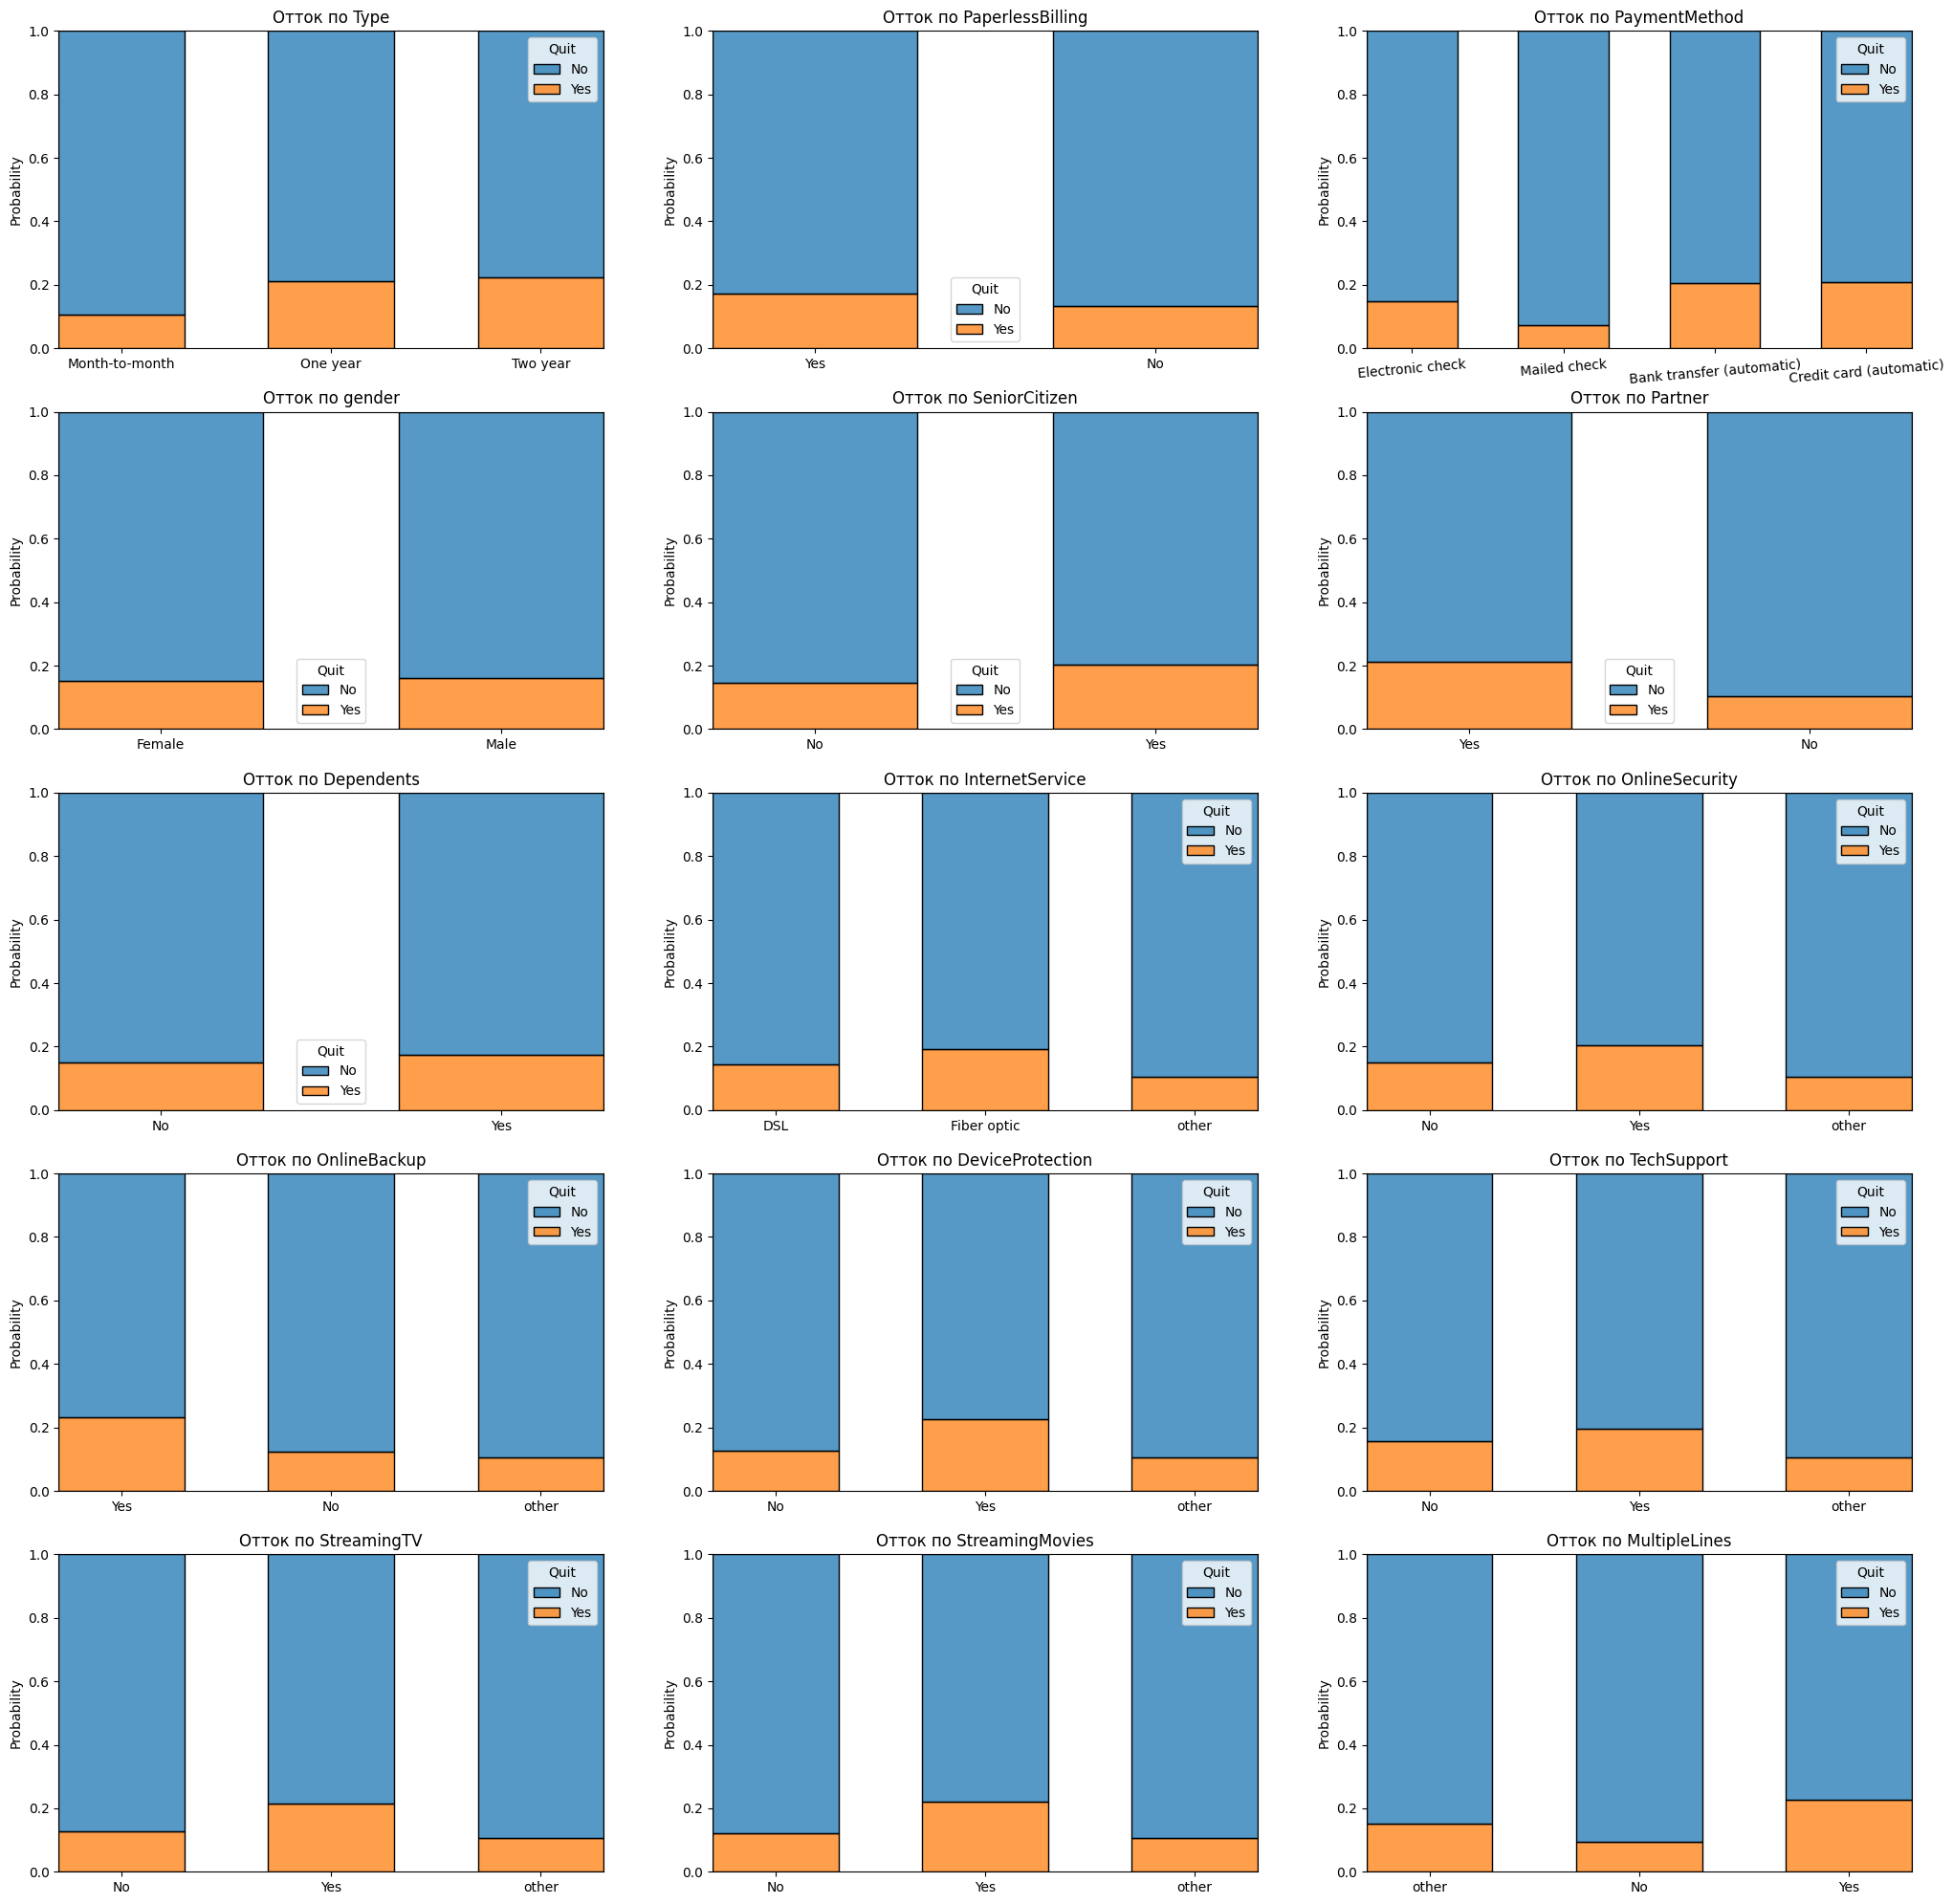

In [24]:
cat_features = full_df.drop('Quit', axis=1).select_dtypes(include='object').columns.to_list()

fig, axes = plt.subplots(5, 3, figsize=(25,25))
axes = axes.flatten()
for i, f in enumerate(cat_features):
    ax = axes[i]
    sns.histplot(data=full_df, x=f, hue='Quit',
                stat='probability', multiple='fill',
                shrink=0.6, ax=ax)
    ax.set_title(f'Отток по {f}')
    if i == 2:
        ax.tick_params(rotation=5, axis='x')
    ax.set_xlabel('')

Из графиков выше сразу видно, что пол и наличие или отсутвие детей никак не влияет на увеличение оттока.<br>
Доля среди тех клиентов, у которых оплата от месяца к месяцу больше остается клиентами, нежели остальные планы. Среди тех клиентов, у которых нет партнера, доля тех, кто ушел сильно меньше, по сравнению с долей тех, у кого есть партнер. Тоже самое с Онлайн Бекапом и защитой устройства, у тех, у кого подключена эта функция больше тех, кто расторгнул контракт.

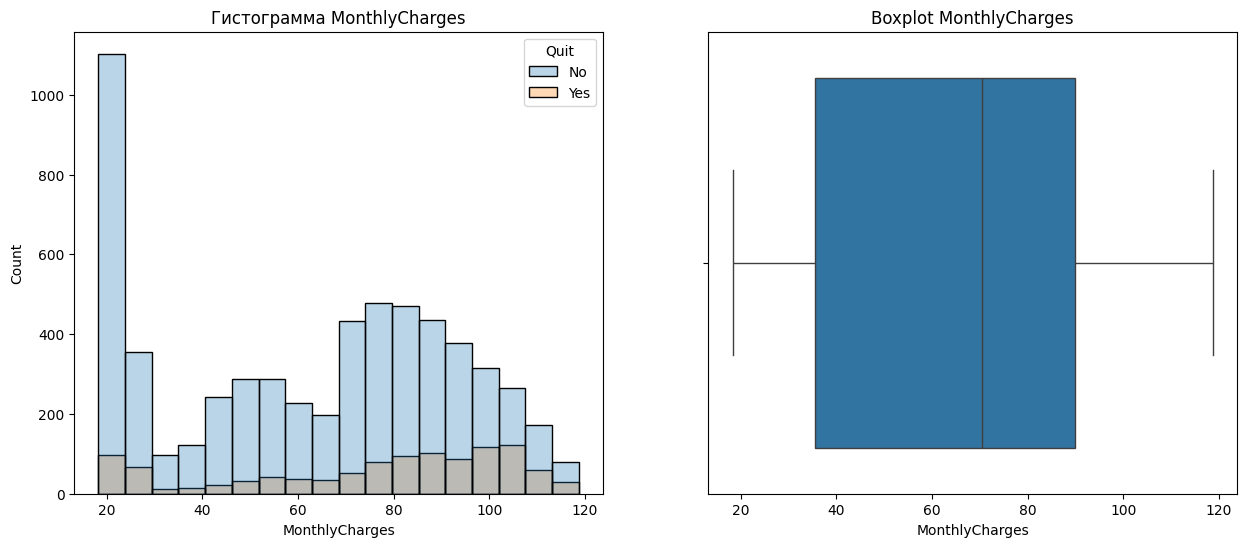

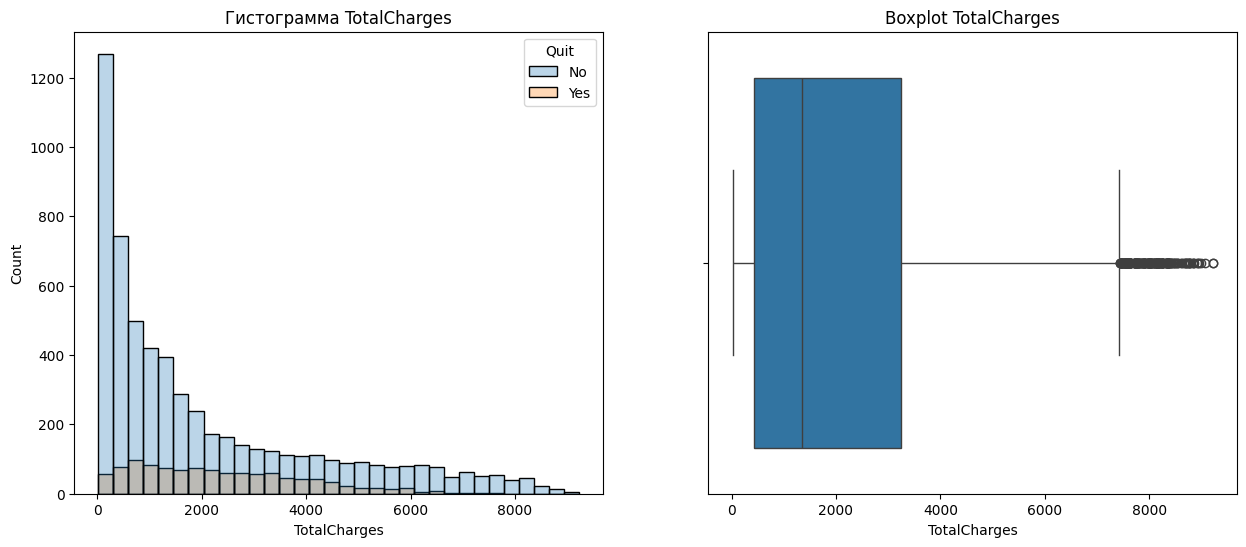

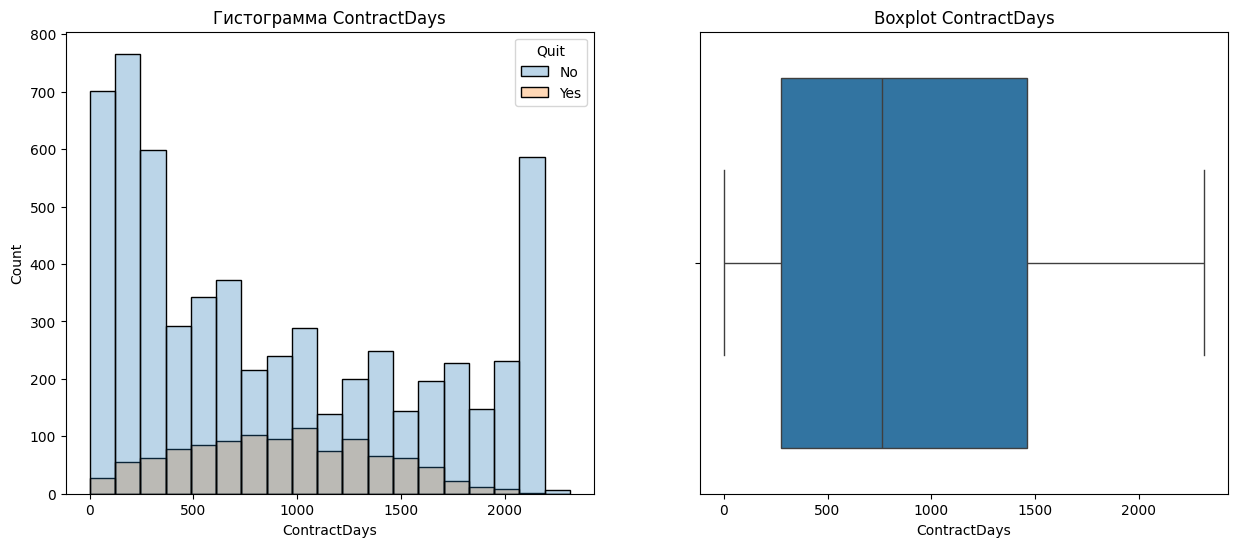

In [25]:
for i in full_df.select_dtypes(include='number').columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.histplot(data=full_df, x=i, hue='Quit', ax=axes[0], alpha=0.3)
    axes[0].set_title(f'Гистограмма {i}')
    sns.boxplot(data=full_df, x=i, ax=axes[1])
    axes[1].set_title(f'Boxplot {i}')

В фичах MonthlyCarges и ContractDays практически нет выбросов. Если смотреть на гистонраммы MonthlyCharges и TotalCharges, то преобладают меньшие значения, по сравнению с остальными.

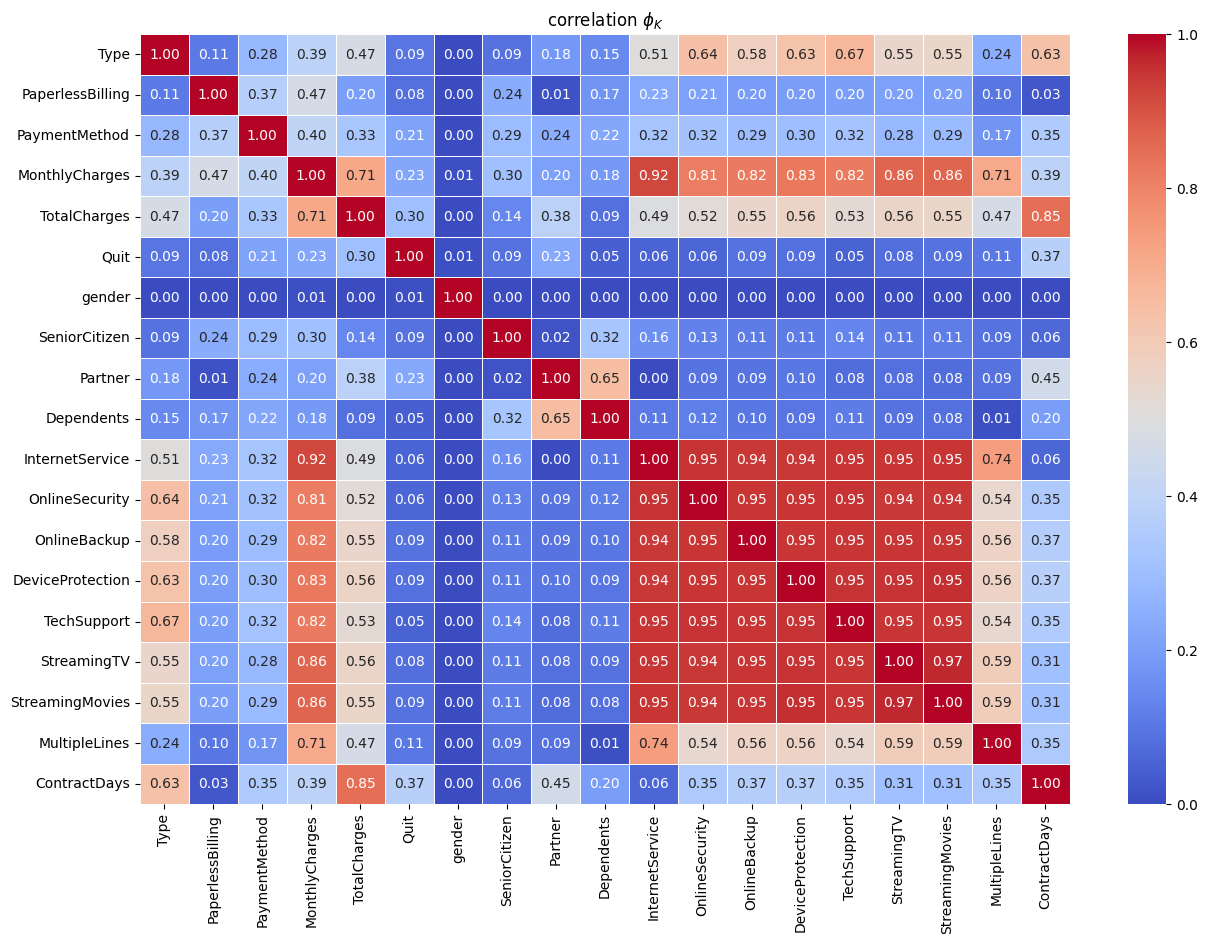

In [26]:
interval_cols = full_df.select_dtypes(include='number').columns.to_list()

plt.figure(figsize=(15, 10))
sns.heatmap(full_df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5);

plt.title(r"correlation $\phi_K$")
plt.show()

По матрице корреляции отчетлива видна сильная корреляция между фичами от InternetService до StreamingMovie от 0.94. Мультиколлениарность может негативно сказать на качестве моделей, особенно линейной. Поэтому удалим все эти фичи, кроме InternetService

In [27]:
full_df.drop(['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1, inplace=True)

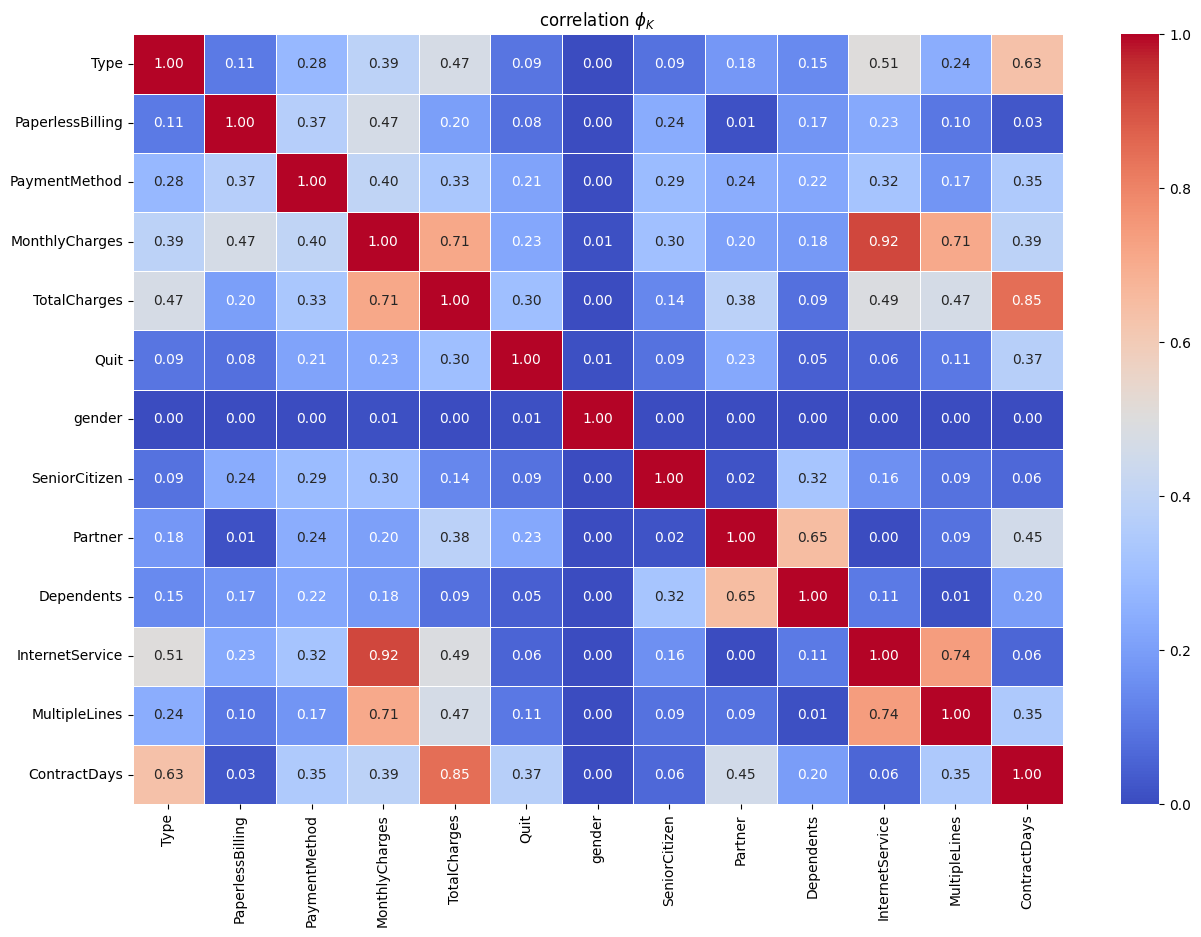

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Quit              7043 non-null   object 
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   object 
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   7043 non-null   object 
 11  MultipleLines     7043 non-null   object 
 12  ContractDays      7043 non-null   int64  
dtypes: float64(2), int64(1), object(10)
memory usage: 715.4+ KB


In [28]:
interval_cols = full_df.select_dtypes(include='number').columns.to_list()

plt.figure(figsize=(15, 10))
sns.heatmap(full_df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5);

plt.title(r"correlation $\phi_K$")
plt.show()

full_df.info()

In [29]:
print(full_df['Quit'].value_counts(normalize=True))

Quit
No     0.843675
Yes    0.156325
Name: proportion, dtype: float64


Видим сильный дисбаланс классов. Поэтому нужно обязательно использовать stratify при разделении выборок. Также во время обучения моделей проставлять параметр class_weight='balanced', где это необходимо

## Подготовка данных

In [30]:
X_train, X_test, y_train, y_test = train_test_split(full_df.drop('Quit', axis=1), full_df['Quit'], stratify=full_df['Quit'], shuffle=True, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape)

label_enc = LabelEncoder()
y_train_lbl = label_enc.fit_transform(y_train)
y_test_lbl = label_enc.transform(y_test)
print(label_enc.classes_)

(5282, 12) (1761, 12)
['No' 'Yes']


No у нас это 0, Yes это 1

## Обучение моделей

In [31]:
def optuna_cv_result(pipe: Pipeline, paramgrid: dict, n_trials: int = 20) -> OptunaSearchCV:
    oscv = OptunaSearchCV(pipe, paramgrid,
                         cv=5, random_state=RANDOM_STATE,
                         scoring='roc_auc', verbose=1, n_trials=n_trials).fit(X_train, y_train_lbl)
    return oscv

Добавим кастомный импутер, который будет обрабатывать пропуски в TotalCharges. Если число дней контракта меньше 30, то значение будет заполняться нулем, если больше или рано 30, то значения будут зполняться среднемесячной суммой за месяц помноженную на количество месяцев контракта. 

In [32]:
class TotalChargesImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, 
                target_col='TotalCharges',
                min_days=30,
                days_per_month=30):
        self.target_col = target_col
        self.min_days = min_days
        self.days_per_month = days_per_month
        
    def fit(self, X, y=None):
        
        df = pd.DataFrame(X)
        self.monthly_mean_ = pd.to_numeric(df['MonthlyCharges'], errors='coerce').mean()
        
        if np.isnan(self.monthly_mean_):
            self.monthly_mean_ = 0.0
            
        return self
    
    def transform(self, X):
        
        df = pd.DataFrame(X).copy()
        
        contract_days = pd.to_numeric(df['ContractDays'], errors='coerce')
        target = pd.to_numeric(df[self.target_col], errors='coerce')
        mask_na = target.isna()
        
        months = np.floor(np.maximum(0, contract_days.astype('float') / float(self.days_per_month)))
        
        to_zero = mask_na & (contract_days < self.min_days)
        to_month = mask_na & (contract_days >= self.min_days)
        
        df.loc[to_zero, self.target_col] = 0.0
        df.loc[to_month, self.target_col] = months[to_month] * float(self.monthly_mean_)
        
        return df.values if not isinstance(X, pd.DataFrame) else df

### Логистическая регрессия

In [33]:
ohe_pipe_linear = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='other')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

ohe_columns = X_train.select_dtypes(include='object').columns.to_list()
num_columns = X_train.select_dtypes(include='number').columns.to_list()

data_preprocessor_linear = ColumnTransformer(
    [
        ('ohe', ohe_pipe_linear, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final_linear = Pipeline(
    [
        ('tch_imputer', TotalChargesImputer()),
        ('preprocessor', data_preprocessor_linear),
        ('models', LogisticRegression(n_jobs=-1, class_weight='balanced', random_state=RANDOM_STATE))
    ]
)    
    
    
param_grid_linear = {
    'preprocessor__num': distributions.CategoricalDistribution([
        MinMaxScaler(), 
        StandardScaler(), 
        RobustScaler(),
    ]),
    'models__C': distributions.FloatDistribution(0.1, 1.0)
}

In [34]:
oscv_lr = optuna_cv_result(pipe_final_linear, param_grid_linear)

[I 2025-08-21 18:55:18,572] A new study created in memory with name: no-name-a4fb9500-06ad-428f-9a1f-d37b31655e41
[I 2025-08-21 18:55:20,320] Trial 0 finished with value: 0.7661470584677585 and parameters: {'preprocessor__num': RobustScaler(), 'models__C': 0.28760754633192726}. Best is trial 0 with value: 0.7661470584677585.
[I 2025-08-21 18:55:22,160] Trial 1 finished with value: 0.7631256223090771 and parameters: {'preprocessor__num': MinMaxScaler(), 'models__C': 0.2520955433171148}. Best is trial 0 with value: 0.7661470584677585.
[I 2025-08-21 18:55:22,937] Trial 2 finished with value: 0.7669246531376448 and parameters: {'preprocessor__num': StandardScaler(), 'models__C': 0.6616416910886571}. Best is trial 2 with value: 0.7669246531376448.
[I 2025-08-21 18:55:23,083] Trial 3 finished with value: 0.7661214469747092 and parameters: {'preprocessor__num': StandardScaler(), 'models__C': 0.1564764290266503}. Best is trial 2 with value: 0.7669246531376448.
[I 2025-08-21 18:55:23,225] Trial

In [35]:
print(f'Лучшая метрика ROC-AUC после кроссвалидации: {oscv_lr.best_score_:.3f}')
print(f'Подобронные гиперпараметры: {oscv_lr.best_params_}')

Лучшая метрика ROC-AUC после кроссвалидации: 0.767
Подобронные гиперпараметры: {'preprocessor__num': StandardScaler(), 'models__C': 0.835054370943564}


Данное значение метрики является неудовлетворительным

### Случайный лес

In [36]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='other')
        ),
        (
            'ord',  
            OrdinalEncoder(handle_unknown='use_encoded_value',
                           unknown_value=-1)
        )
    ]
) 


ord_columns = X_train.select_dtypes(include='object').columns.to_list()

data_preprocessor_not_lr = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns)
    ],
    remainder='passthrough'
)

pipe_final_rfc = Pipeline(
    [
        ('tch_imputer', TotalChargesImputer()),
        ('preprocessor', data_preprocessor_not_lr),
        ('models', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
    ]
)    
    
    
param_grid_rfc = {
    'models__n_estimators': distributions.IntDistribution(100, 150),
    'models__criterion': distributions.CategoricalDistribution(['gini', 'entropy']),
    'models__max_depth': distributions.IntDistribution(1, 100),
    'models__min_samples_split': distributions.IntDistribution(2, 50),
    'models__min_samples_leaf': distributions.IntDistribution(1, 50),
}

In [37]:
oscv_rfc = optuna_cv_result(pipe_final_rfc, param_grid_rfc)

[I 2025-08-21 18:55:25,444] A new study created in memory with name: no-name-58c7d2dc-ee57-40fe-8e1a-7fe59b108466
[I 2025-08-21 18:55:27,271] Trial 0 finished with value: 0.8308991706218171 and parameters: {'models__n_estimators': 142, 'models__criterion': 'entropy', 'models__max_depth': 21, 'models__min_samples_split': 35, 'models__min_samples_leaf': 27}. Best is trial 0 with value: 0.8308991706218171.
[I 2025-08-21 18:55:28,576] Trial 1 finished with value: 0.8301442657871416 and parameters: {'models__n_estimators': 100, 'models__criterion': 'entropy', 'models__max_depth': 50, 'models__min_samples_split': 21, 'models__min_samples_leaf': 32}. Best is trial 0 with value: 0.8308991706218171.
[I 2025-08-21 18:55:29,998] Trial 2 finished with value: 0.8279520284169865 and parameters: {'models__n_estimators': 129, 'models__criterion': 'gini', 'models__max_depth': 7, 'models__min_samples_split': 14, 'models__min_samples_leaf': 44}. Best is trial 0 with value: 0.8308991706218171.
[I 2025-08-

In [38]:
print(f'Лучшая метрика ROC-AUC на кроссвалидации: {oscv_rfc.best_score_:.2f}')
print(f"Параметры лучшей модели: {oscv_rfc.best_params_}")

Лучшая метрика ROC-AUC на кроссвалидации: 0.83
Параметры лучшей модели: {'models__n_estimators': 134, 'models__criterion': 'entropy', 'models__max_depth': 100, 'models__min_samples_split': 41, 'models__min_samples_leaf': 19}


ROC-AUC также не дотягивает до необходимого порога.

### CatBoost

In [39]:
cat_features = X_train.select_dtypes(include='object').columns.to_list()

simp_imp_cat = Pipeline([
    (
        'simple_imputer',
        SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='other')
    )
])

preprocessor_cb = ColumnTransformer(
    [
        ('cat', simp_imp_cat, cat_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

preprocessor_cb.set_output(transform='pandas')

pipe_final_cb = Pipeline(
    [   
        ('tch_imputer', TotalChargesImputer()),
        ('preprocessor', preprocessor_cb),
        ('models', CatBoostClassifier(random_state=RANDOM_STATE))
    ]
)  

param_grid_cb = {
    'models__iterations': distributions.IntDistribution(300, 500),
    'models__learning_rate': distributions.FloatDistribution(0.01, 0.1),
    'models__depth': distributions.IntDistribution(4, 10),
    'models__l2_leaf_reg': distributions.IntDistribution(1, 10),
    'models__bagging_temperature': distributions.IntDistribution(0, 5)
}

In [40]:
oscv_cb = OptunaSearchCV(
    pipe_final_cb,
    param_grid_cb,
    cv=5, random_state=RANDOM_STATE,
    scoring='roc_auc', verbose=1, n_trials=20).fit(X_train, y_train_lbl, **{'models__cat_features':cat_features})

[I 2025-08-21 18:55:59,414] A new study created in memory with name: no-name-9ac24d56-317e-48de-b1a6-c29fc4bdd354


0:	learn: 0.6563211	total: 168ms	remaining: 1m 18s
1:	learn: 0.6142229	total: 189ms	remaining: 43.9s
2:	learn: 0.5815800	total: 204ms	remaining: 31.5s
3:	learn: 0.5516984	total: 232ms	remaining: 26.9s
4:	learn: 0.5248974	total: 264ms	remaining: 24.4s
5:	learn: 0.5099185	total: 274ms	remaining: 21.1s
6:	learn: 0.4882919	total: 299ms	remaining: 19.6s
7:	learn: 0.4780959	total: 305ms	remaining: 17.5s
8:	learn: 0.4690128	total: 309ms	remaining: 15.7s
9:	learn: 0.4541330	total: 326ms	remaining: 14.9s
10:	learn: 0.4429991	total: 335ms	remaining: 13.9s
11:	learn: 0.4369336	total: 339ms	remaining: 12.9s
12:	learn: 0.4251865	total: 365ms	remaining: 12.8s
13:	learn: 0.4135087	total: 397ms	remaining: 12.8s
14:	learn: 0.4027673	total: 429ms	remaining: 12.9s
15:	learn: 0.3942739	total: 446ms	remaining: 12.6s
16:	learn: 0.3851849	total: 481ms	remaining: 12.7s
17:	learn: 0.3754828	total: 512ms	remaining: 12.8s
18:	learn: 0.3668471	total: 545ms	remaining: 12.8s
19:	learn: 0.3620747	total: 561ms	remain

[I 2025-08-21 18:57:02,511] Trial 0 finished with value: 0.8652381581800631 and parameters: {'models__iterations': 467, 'models__learning_rate': 0.050082207558027454, 'models__depth': 10, 'models__l2_leaf_reg': 3, 'models__bagging_temperature': 4}. Best is trial 0 with value: 0.8652381581800631.


464:	learn: 0.1185490	total: 12.1s	remaining: 52.1ms
465:	learn: 0.1183779	total: 12.1s	remaining: 26ms
466:	learn: 0.1182497	total: 12.2s	remaining: 0us
0:	learn: 0.6850039	total: 12.3ms	remaining: 5.01s
1:	learn: 0.6763250	total: 23.9ms	remaining: 4.84s
2:	learn: 0.6679195	total: 34.1ms	remaining: 4.61s
3:	learn: 0.6592419	total: 44.4ms	remaining: 4.48s
4:	learn: 0.6507367	total: 54.9ms	remaining: 4.43s
5:	learn: 0.6428274	total: 69.2ms	remaining: 4.64s
6:	learn: 0.6364597	total: 83.6ms	remaining: 4.79s
7:	learn: 0.6296265	total: 94.7ms	remaining: 4.74s
8:	learn: 0.6247195	total: 98.3ms	remaining: 4.36s
9:	learn: 0.6199327	total: 103ms	remaining: 4.12s
10:	learn: 0.6127938	total: 114ms	remaining: 4.13s
11:	learn: 0.6069568	total: 124ms	remaining: 4.11s
12:	learn: 0.5996609	total: 137ms	remaining: 4.17s
13:	learn: 0.5930768	total: 148ms	remaining: 4.17s
14:	learn: 0.5889343	total: 152ms	remaining: 3.97s
15:	learn: 0.5842972	total: 160ms	remaining: 3.91s
16:	learn: 0.5784327	total: 172

[I 2025-08-21 18:57:24,790] Trial 1 finished with value: 0.8361615691310146 and parameters: {'models__iterations': 408, 'models__learning_rate': 0.010751165604910948, 'models__depth': 5, 'models__l2_leaf_reg': 5, 'models__bagging_temperature': 2}. Best is trial 0 with value: 0.8652381581800631.


0:	learn: 0.6451982	total: 17.9ms	remaining: 6.8s
1:	learn: 0.5943503	total: 34.3ms	remaining: 6.5s
2:	learn: 0.5551346	total: 48.8ms	remaining: 6.15s
3:	learn: 0.5237776	total: 66.8ms	remaining: 6.3s
4:	learn: 0.4968262	total: 81.3ms	remaining: 6.11s
5:	learn: 0.4741822	total: 97.6ms	remaining: 6.1s
6:	learn: 0.4571945	total: 109ms	remaining: 5.82s
7:	learn: 0.4418733	total: 120ms	remaining: 5.58s
8:	learn: 0.4293039	total: 135ms	remaining: 5.57s
9:	learn: 0.4190879	total: 151ms	remaining: 5.59s
10:	learn: 0.4132913	total: 154ms	remaining: 5.2s
11:	learn: 0.4083015	total: 158ms	remaining: 4.85s
12:	learn: 0.3971392	total: 173ms	remaining: 4.9s
13:	learn: 0.3935720	total: 177ms	remaining: 4.63s
14:	learn: 0.3857994	total: 191ms	remaining: 4.65s
15:	learn: 0.3770746	total: 207ms	remaining: 4.71s
16:	learn: 0.3717074	total: 219ms	remaining: 4.7s
17:	learn: 0.3663066	total: 235ms	remaining: 4.74s
18:	learn: 0.3610917	total: 248ms	remaining: 4.72s
19:	learn: 0.3593334	total: 253ms	remainin

[I 2025-08-21 18:57:54,857] Trial 2 finished with value: 0.8735295824790399 and parameters: {'models__iterations': 381, 'models__learning_rate': 0.06616416910886572, 'models__depth': 7, 'models__l2_leaf_reg': 10, 'models__bagging_temperature': 4}. Best is trial 2 with value: 0.8735295824790399.


369:	learn: 0.2198390	total: 5.64s	remaining: 168ms
370:	learn: 0.2196387	total: 5.66s	remaining: 152ms
371:	learn: 0.2195513	total: 5.67s	remaining: 137ms
372:	learn: 0.2192147	total: 5.69s	remaining: 122ms
373:	learn: 0.2185229	total: 5.71s	remaining: 107ms
374:	learn: 0.2183203	total: 5.72s	remaining: 91.6ms
375:	learn: 0.2183074	total: 5.74s	remaining: 76.3ms
376:	learn: 0.2180827	total: 5.75s	remaining: 61ms
377:	learn: 0.2177973	total: 5.77s	remaining: 45.8ms
378:	learn: 0.2175253	total: 5.78s	remaining: 30.5ms
379:	learn: 0.2173635	total: 5.8s	remaining: 15.3ms
380:	learn: 0.2170912	total: 5.82s	remaining: 0us
0:	learn: 0.6687511	total: 17.4ms	remaining: 5.4s
1:	learn: 0.6392111	total: 35.5ms	remaining: 5.5s
2:	learn: 0.6153894	total: 50.8ms	remaining: 5.23s
3:	learn: 0.5921845	total: 72.3ms	remaining: 5.57s
4:	learn: 0.5795170	total: 76.8ms	remaining: 4.72s
5:	learn: 0.5581651	total: 98ms	remaining: 5s
6:	learn: 0.5423890	total: 113ms	remaining: 4.94s
7:	learn: 0.5316811	total:

[I 2025-08-21 18:58:30,527] Trial 3 finished with value: 0.8302825756295485 and parameters: {'models__iterations': 312, 'models__learning_rate': 0.032731125292688054, 'models__depth': 10, 'models__l2_leaf_reg': 1, 'models__bagging_temperature': 5}. Best is trial 2 with value: 0.8735295824790399.


0:	learn: 0.6748954	total: 22.1ms	remaining: 9.96s
1:	learn: 0.6536547	total: 50.8ms	remaining: 11.4s
2:	learn: 0.6349417	total: 73.7ms	remaining: 11s
3:	learn: 0.6163268	total: 101ms	remaining: 11.3s
4:	learn: 0.6058147	total: 108ms	remaining: 9.7s
5:	learn: 0.5907658	total: 130ms	remaining: 9.67s
6:	learn: 0.5737168	total: 156ms	remaining: 9.9s
7:	learn: 0.5572489	total: 181ms	remaining: 10.1s
8:	learn: 0.5427520	total: 207ms	remaining: 10.2s
9:	learn: 0.5346405	total: 218ms	remaining: 9.64s
10:	learn: 0.5277140	total: 222ms	remaining: 8.91s
11:	learn: 0.5151062	total: 248ms	remaining: 9.11s
12:	learn: 0.5042648	total: 274ms	remaining: 9.25s
13:	learn: 0.4940372	total: 300ms	remaining: 9.4s
14:	learn: 0.4838405	total: 329ms	remaining: 9.58s
15:	learn: 0.4755830	total: 345ms	remaining: 9.41s
16:	learn: 0.4705215	total: 352ms	remaining: 9.01s
17:	learn: 0.4630319	total: 374ms	remaining: 9.02s
18:	learn: 0.4570843	total: 400ms	remaining: 9.11s
19:	learn: 0.4496189	total: 424ms	remaining

[I 2025-08-21 18:59:19,276] Trial 4 finished with value: 0.8434059009177366 and parameters: {'models__iterations': 452, 'models__learning_rate': 0.02433233952813956, 'models__depth': 9, 'models__l2_leaf_reg': 2, 'models__bagging_temperature': 5}. Best is trial 2 with value: 0.8735295824790399.


449:	learn: 0.2113013	total: 9.52s	remaining: 42.3ms
450:	learn: 0.2111385	total: 9.54s	remaining: 21.2ms
451:	learn: 0.2110001	total: 9.57s	remaining: 0us
0:	learn: 0.6615040	total: 18.2ms	remaining: 7.41s
1:	learn: 0.6254388	total: 34.1ms	remaining: 6.9s
2:	learn: 0.5962350	total: 48.9ms	remaining: 6.59s
3:	learn: 0.5703868	total: 73.2ms	remaining: 7.37s
4:	learn: 0.5555693	total: 79.4ms	remaining: 6.38s
5:	learn: 0.5355162	total: 93.2ms	remaining: 6.23s
6:	learn: 0.5192750	total: 116ms	remaining: 6.6s
7:	learn: 0.5086285	total: 119ms	remaining: 5.95s
8:	learn: 0.4981511	total: 128ms	remaining: 5.64s
9:	learn: 0.4883874	total: 136ms	remaining: 5.42s
10:	learn: 0.4794437	total: 143ms	remaining: 5.14s
11:	learn: 0.4660572	total: 158ms	remaining: 5.2s
12:	learn: 0.4572530	total: 173ms	remaining: 5.25s
13:	learn: 0.4459855	total: 192ms	remaining: 5.39s
14:	learn: 0.4373009	total: 203ms	remaining: 5.3s
15:	learn: 0.4258201	total: 224ms	remaining: 5.48s
16:	learn: 0.4159721	total: 253ms	re

[I 2025-08-21 19:00:05,947] Trial 5 finished with value: 0.8599299150690911 and parameters: {'models__iterations': 407, 'models__learning_rate': 0.042835358440066945, 'models__depth': 9, 'models__l2_leaf_reg': 7, 'models__bagging_temperature': 5}. Best is trial 2 with value: 0.8735295824790399.


403:	learn: 0.2037044	total: 9.05s	remaining: 67.2ms
404:	learn: 0.2034879	total: 9.08s	remaining: 44.8ms
405:	learn: 0.2034182	total: 9.1s	remaining: 22.4ms
406:	learn: 0.2033229	total: 9.13s	remaining: 0us
0:	learn: 0.6248003	total: 14.2ms	remaining: 6.89s
1:	learn: 0.5656737	total: 28.8ms	remaining: 6.99s
2:	learn: 0.5162129	total: 45.7ms	remaining: 7.37s
3:	learn: 0.4810532	total: 60.4ms	remaining: 7.29s
4:	learn: 0.4616194	total: 65.7ms	remaining: 6.34s
5:	learn: 0.4399303	total: 74.7ms	remaining: 5.98s
6:	learn: 0.4170678	total: 87.6ms	remaining: 6.01s
7:	learn: 0.4092931	total: 96.1ms	remaining: 5.75s
8:	learn: 0.3989809	total: 107ms	remaining: 5.7s
9:	learn: 0.3833160	total: 122ms	remaining: 5.8s
10:	learn: 0.3724316	total: 136ms	remaining: 5.9s
11:	learn: 0.3620141	total: 150ms	remaining: 5.94s
12:	learn: 0.3594777	total: 156ms	remaining: 5.7s
13:	learn: 0.3520136	total: 170ms	remaining: 5.73s
14:	learn: 0.3449895	total: 186ms	remaining: 5.85s
15:	learn: 0.3426508	total: 207ms

[I 2025-08-21 19:00:41,114] Trial 6 finished with value: 0.9019524550586862 and parameters: {'models__iterations': 487, 'models__learning_rate': 0.096381946991042, 'models__depth': 6, 'models__l2_leaf_reg': 1, 'models__bagging_temperature': 0}. Best is trial 6 with value: 0.9019524550586862.


0:	learn: 0.6449030	total: 14.1ms	remaining: 5.41s
1:	learn: 0.5997944	total: 28.9ms	remaining: 5.53s
2:	learn: 0.5589966	total: 42.6ms	remaining: 5.42s
3:	learn: 0.5274905	total: 56.4ms	remaining: 5.37s
4:	learn: 0.5018599	total: 71ms	remaining: 5.39s
5:	learn: 0.4802462	total: 84.4ms	remaining: 5.33s
6:	learn: 0.4649557	total: 116ms	remaining: 6.29s
7:	learn: 0.4480517	total: 131ms	remaining: 6.17s
8:	learn: 0.4392753	total: 139ms	remaining: 5.79s
9:	learn: 0.4321058	total: 142ms	remaining: 5.34s
10:	learn: 0.4197646	total: 156ms	remaining: 5.29s
11:	learn: 0.4084250	total: 168ms	remaining: 5.22s
12:	learn: 0.3996935	total: 183ms	remaining: 5.22s
13:	learn: 0.3900214	total: 196ms	remaining: 5.2s
14:	learn: 0.3858088	total: 204ms	remaining: 5.04s
15:	learn: 0.3796239	total: 217ms	remaining: 5s
16:	learn: 0.3738201	total: 231ms	remaining: 5.01s
17:	learn: 0.3687283	total: 245ms	remaining: 4.99s
18:	learn: 0.3628563	total: 261ms	remaining: 5.02s
19:	learn: 0.3601079	total: 270ms	remaini

[I 2025-08-21 19:01:07,050] Trial 7 finished with value: 0.8758306450139799 and parameters: {'models__iterations': 385, 'models__learning_rate': 0.06659387980422546, 'models__depth': 6, 'models__l2_leaf_reg': 10, 'models__bagging_temperature': 2}. Best is trial 6 with value: 0.9019524550586862.


377:	learn: 0.2317364	total: 4.74s	remaining: 87.7ms
378:	learn: 0.2314038	total: 4.75s	remaining: 75.2ms
379:	learn: 0.2310739	total: 4.76s	remaining: 62.6ms
380:	learn: 0.2306011	total: 4.77s	remaining: 50.1ms
381:	learn: 0.2305893	total: 4.79s	remaining: 37.6ms
382:	learn: 0.2305363	total: 4.8s	remaining: 25.1ms
383:	learn: 0.2305354	total: 4.81s	remaining: 12.5ms
384:	learn: 0.2304264	total: 4.82s	remaining: 0us
0:	learn: 0.6656455	total: 18.6ms	remaining: 6.09s
1:	learn: 0.6336932	total: 35.3ms	remaining: 5.78s
2:	learn: 0.6075023	total: 53.1ms	remaining: 5.77s
3:	learn: 0.5845921	total: 71.7ms	remaining: 5.83s
4:	learn: 0.5635510	total: 89.4ms	remaining: 5.79s
5:	learn: 0.5439114	total: 105ms	remaining: 5.63s
6:	learn: 0.5259770	total: 123ms	remaining: 5.64s
7:	learn: 0.5118001	total: 135ms	remaining: 5.4s
8:	learn: 0.4979494	total: 150ms	remaining: 5.32s
9:	learn: 0.4840012	total: 167ms	remaining: 5.33s
10:	learn: 0.4711310	total: 182ms	remaining: 5.27s
11:	learn: 0.4631307	tota

[I 2025-08-21 19:01:31,487] Trial 8 finished with value: 0.8502658675374569 and parameters: {'models__iterations': 329, 'models__learning_rate': 0.037052692778315355, 'models__depth': 7, 'models__l2_leaf_reg': 6, 'models__bagging_temperature': 0}. Best is trial 6 with value: 0.9019524550586862.


326:	learn: 0.2588856	total: 4.65s	remaining: 28.5ms
327:	learn: 0.2588077	total: 4.67s	remaining: 14.2ms
328:	learn: 0.2587053	total: 4.69s	remaining: 0us
0:	learn: 0.6699773	total: 18.4ms	remaining: 6.14s
1:	learn: 0.6420455	total: 33.9ms	remaining: 5.65s
2:	learn: 0.6192326	total: 52.3ms	remaining: 5.78s
3:	learn: 0.5969607	total: 73.6ms	remaining: 6.09s
4:	learn: 0.5846715	total: 79.7ms	remaining: 5.26s
5:	learn: 0.5643290	total: 103ms	remaining: 5.65s
6:	learn: 0.5489011	total: 124ms	remaining: 5.8s
7:	learn: 0.5355122	total: 135ms	remaining: 5.52s
8:	learn: 0.5222020	total: 144ms	remaining: 5.21s
9:	learn: 0.5089645	total: 166ms	remaining: 5.4s
10:	learn: 0.5015813	total: 172ms	remaining: 5.06s
11:	learn: 0.4886257	total: 195ms	remaining: 5.25s
12:	learn: 0.4774318	total: 213ms	remaining: 5.27s
13:	learn: 0.4653797	total: 234ms	remaining: 5.36s
14:	learn: 0.4557733	total: 254ms	remaining: 5.42s
15:	learn: 0.4495837	total: 263ms	remaining: 5.24s
16:	learn: 0.4404939	total: 283ms	r

[I 2025-08-21 19:02:06,329] Trial 9 finished with value: 0.8393265106124972 and parameters: {'models__iterations': 335, 'models__learning_rate': 0.031047560356608488, 'models__depth': 9, 'models__l2_leaf_reg': 2, 'models__bagging_temperature': 1}. Best is trial 6 with value: 0.9019524550586862.


334:	learn: 0.2125646	total: 6.6s	remaining: 0us
0:	learn: 0.6298691	total: 8.75ms	remaining: 4.37s
1:	learn: 0.5818518	total: 18ms	remaining: 4.49s
2:	learn: 0.5323522	total: 27.3ms	remaining: 4.52s
3:	learn: 0.4943511	total: 36.7ms	remaining: 4.55s
4:	learn: 0.4703654	total: 44.5ms	remaining: 4.4s
5:	learn: 0.4435563	total: 53.4ms	remaining: 4.4s
6:	learn: 0.4227602	total: 62.6ms	remaining: 4.41s
7:	learn: 0.4115229	total: 69.1ms	remaining: 4.25s
8:	learn: 0.3982042	total: 80.6ms	remaining: 4.39s
9:	learn: 0.3903929	total: 89.4ms	remaining: 4.38s
10:	learn: 0.3799524	total: 98.7ms	remaining: 4.39s
11:	learn: 0.3747155	total: 108ms	remaining: 4.41s
12:	learn: 0.3694360	total: 117ms	remaining: 4.37s
13:	learn: 0.3650355	total: 126ms	remaining: 4.39s
14:	learn: 0.3592852	total: 136ms	remaining: 4.4s
15:	learn: 0.3538017	total: 147ms	remaining: 4.45s
16:	learn: 0.3519251	total: 156ms	remaining: 4.45s
17:	learn: 0.3477741	total: 164ms	remaining: 4.4s
18:	learn: 0.3445423	total: 173ms	rema

[I 2025-08-21 19:02:30,532] Trial 10 finished with value: 0.9012049444286724 and parameters: {'models__iterations': 500, 'models__learning_rate': 0.09621252422975171, 'models__depth': 4, 'models__l2_leaf_reg': 4, 'models__bagging_temperature': 0}. Best is trial 6 with value: 0.9019524550586862.


498:	learn: 0.1942411	total: 4.65s	remaining: 9.31ms
499:	learn: 0.1937896	total: 4.65s	remaining: 0us
0:	learn: 0.6287735	total: 9.82ms	remaining: 4.89s
1:	learn: 0.5801386	total: 17.2ms	remaining: 4.29s
2:	learn: 0.5301967	total: 26.2ms	remaining: 4.34s
3:	learn: 0.4920472	total: 36.3ms	remaining: 4.49s
4:	learn: 0.4681077	total: 44.1ms	remaining: 4.36s
5:	learn: 0.4413675	total: 53.1ms	remaining: 4.37s
6:	learn: 0.4206968	total: 61.5ms	remaining: 4.32s
7:	learn: 0.4096010	total: 68.8ms	remaining: 4.22s
8:	learn: 0.3956008	total: 77.5ms	remaining: 4.22s
9:	learn: 0.3847912	total: 85.7ms	remaining: 4.19s
10:	learn: 0.3739027	total: 95.7ms	remaining: 4.25s
11:	learn: 0.3708017	total: 100ms	remaining: 4.07s
12:	learn: 0.3648579	total: 109ms	remaining: 4.08s
13:	learn: 0.3597651	total: 118ms	remaining: 4.07s
14:	learn: 0.3544388	total: 128ms	remaining: 4.13s
15:	learn: 0.3507593	total: 140ms	remaining: 4.21s
16:	learn: 0.3478344	total: 166ms	remaining: 4.72s
17:	learn: 0.3459583	total: 1

[I 2025-08-21 19:02:54,980] Trial 11 finished with value: 0.9000363622530998 and parameters: {'models__iterations': 499, 'models__learning_rate': 0.09801175567443773, 'models__depth': 4, 'models__l2_leaf_reg': 4, 'models__bagging_temperature': 0}. Best is trial 6 with value: 0.9019524550586862.


488:	learn: 0.1916535	total: 4.63s	remaining: 94.6ms
489:	learn: 0.1915186	total: 4.64s	remaining: 85.2ms
490:	learn: 0.1913612	total: 4.65s	remaining: 75.7ms
491:	learn: 0.1913284	total: 4.66s	remaining: 66.3ms
492:	learn: 0.1912429	total: 4.67s	remaining: 56.8ms
493:	learn: 0.1910555	total: 4.67s	remaining: 47.3ms
494:	learn: 0.1908892	total: 4.69s	remaining: 37.9ms
495:	learn: 0.1907553	total: 4.7s	remaining: 28.4ms
496:	learn: 0.1907332	total: 4.71s	remaining: 18.9ms
497:	learn: 0.1906574	total: 4.71s	remaining: 9.47ms
498:	learn: 0.1906319	total: 4.72s	remaining: 0us
0:	learn: 0.6287753	total: 9.58ms	remaining: 4.73s
1:	learn: 0.5734465	total: 17.3ms	remaining: 4.28s
2:	learn: 0.5336262	total: 25.2ms	remaining: 4.13s
3:	learn: 0.5021846	total: 35.1ms	remaining: 4.3s
4:	learn: 0.4728444	total: 44.7ms	remaining: 4.38s
5:	learn: 0.4449636	total: 54.4ms	remaining: 4.43s
6:	learn: 0.4281759	total: 67.1ms	remaining: 4.67s
7:	learn: 0.4153341	total: 80.3ms	remaining: 4.89s
8:	learn: 0.40

[I 2025-08-21 19:03:19,314] Trial 12 finished with value: 0.9068725421469022 and parameters: {'models__iterations': 495, 'models__learning_rate': 0.09800576921111297, 'models__depth': 4, 'models__l2_leaf_reg': 1, 'models__bagging_temperature': 1}. Best is trial 12 with value: 0.9068725421469022.


0:	learn: 0.6338399	total: 13.6ms	remaining: 6.1s
1:	learn: 0.5807778	total: 27.1ms	remaining: 6.09s
2:	learn: 0.5347802	total: 40.2ms	remaining: 6s
3:	learn: 0.5007490	total: 53.9ms	remaining: 6.02s
4:	learn: 0.4810760	total: 60.4ms	remaining: 5.39s
5:	learn: 0.4589296	total: 69.6ms	remaining: 5.16s
6:	learn: 0.4353735	total: 81.3ms	remaining: 5.16s
7:	learn: 0.4264601	total: 88.7ms	remaining: 4.91s
8:	learn: 0.4120491	total: 101ms	remaining: 4.97s
9:	learn: 0.4016090	total: 115ms	remaining: 5.06s
10:	learn: 0.3926566	total: 125ms	remaining: 4.99s
11:	learn: 0.3856686	total: 132ms	remaining: 4.82s
12:	learn: 0.3752521	total: 145ms	remaining: 4.9s
13:	learn: 0.3699859	total: 158ms	remaining: 4.94s
14:	learn: 0.3612629	total: 170ms	remaining: 4.95s
15:	learn: 0.3559092	total: 183ms	remaining: 4.97s
16:	learn: 0.3515412	total: 198ms	remaining: 5.04s
17:	learn: 0.3465683	total: 210ms	remaining: 5.05s
18:	learn: 0.3423581	total: 224ms	remaining: 5.09s
19:	learn: 0.3393630	total: 239ms	rema

[I 2025-08-21 19:03:50,719] Trial 13 finished with value: 0.8985920240873414 and parameters: {'models__iterations': 451, 'models__learning_rate': 0.08273106430970485, 'models__depth': 6, 'models__l2_leaf_reg': 1, 'models__bagging_temperature': 1}. Best is trial 12 with value: 0.9068725421469022.


448:	learn: 0.1295255	total: 6.12s	remaining: 27.2ms
449:	learn: 0.1294018	total: 6.13s	remaining: 13.6ms
450:	learn: 0.1291791	total: 6.15s	remaining: 0us
0:	learn: 0.6336829	total: 10.3ms	remaining: 4.92s
1:	learn: 0.5815645	total: 22.1ms	remaining: 5.26s
2:	learn: 0.5434550	total: 32.4ms	remaining: 5.13s
3:	learn: 0.5059763	total: 45.4ms	remaining: 5.38s
4:	learn: 0.4755828	total: 54.9ms	remaining: 5.19s
5:	learn: 0.4547463	total: 66.3ms	remaining: 5.22s
6:	learn: 0.4347348	total: 75.5ms	remaining: 5.08s
7:	learn: 0.4236349	total: 83.9ms	remaining: 4.93s
8:	learn: 0.4083712	total: 93.9ms	remaining: 4.89s
9:	learn: 0.3965174	total: 106ms	remaining: 4.94s
10:	learn: 0.3868290	total: 121ms	remaining: 5.13s
11:	learn: 0.3816717	total: 131ms	remaining: 5.09s
12:	learn: 0.3716217	total: 143ms	remaining: 5.1s
13:	learn: 0.3662657	total: 154ms	remaining: 5.09s
14:	learn: 0.3611594	total: 166ms	remaining: 5.11s
15:	learn: 0.3582708	total: 173ms	remaining: 5s
16:	learn: 0.3538090	total: 184ms

[I 2025-08-21 19:04:18,359] Trial 14 finished with value: 0.9030753420665019 and parameters: {'models__iterations': 478, 'models__learning_rate': 0.08296554080220747, 'models__depth': 5, 'models__l2_leaf_reg': 1, 'models__bagging_temperature': 1}. Best is trial 12 with value: 0.9068725421469022.


0:	learn: 0.6352346	total: 13ms	remaining: 5.63s
1:	learn: 0.5846056	total: 27.5ms	remaining: 5.95s
2:	learn: 0.5469892	total: 38.1ms	remaining: 5.49s
3:	learn: 0.5097547	total: 49.8ms	remaining: 5.37s
4:	learn: 0.4798527	total: 61.5ms	remaining: 5.29s
5:	learn: 0.4639977	total: 67.3ms	remaining: 4.81s
6:	learn: 0.4450705	total: 77.7ms	remaining: 4.75s
7:	learn: 0.4279834	total: 90.2ms	remaining: 4.81s
8:	learn: 0.4158639	total: 101ms	remaining: 4.76s
9:	learn: 0.4005073	total: 111ms	remaining: 4.7s
10:	learn: 0.3947202	total: 118ms	remaining: 4.55s
11:	learn: 0.3860379	total: 129ms	remaining: 4.56s
12:	learn: 0.3794479	total: 139ms	remaining: 4.53s
13:	learn: 0.3720639	total: 151ms	remaining: 4.53s
14:	learn: 0.3650066	total: 162ms	remaining: 4.53s
15:	learn: 0.3631267	total: 170ms	remaining: 4.45s
16:	learn: 0.3594605	total: 180ms	remaining: 4.43s
17:	learn: 0.3547353	total: 190ms	remaining: 4.39s
18:	learn: 0.3515457	total: 202ms	remaining: 4.41s
19:	learn: 0.3477797	total: 214ms	re

[I 2025-08-21 19:04:43,314] Trial 15 finished with value: 0.8863916351443576 and parameters: {'models__iterations': 435, 'models__learning_rate': 0.0807793106039671, 'models__depth': 5, 'models__l2_leaf_reg': 8, 'models__bagging_temperature': 1}. Best is trial 12 with value: 0.9068725421469022.


0:	learn: 0.6378305	total: 9.6ms	remaining: 4.52s
1:	learn: 0.5944797	total: 18.1ms	remaining: 4.25s
2:	learn: 0.5586582	total: 28.3ms	remaining: 4.42s
3:	learn: 0.5271632	total: 35.2ms	remaining: 4.12s
4:	learn: 0.4977836	total: 45.8ms	remaining: 4.28s
5:	learn: 0.4709975	total: 55.5ms	remaining: 4.31s
6:	learn: 0.4536382	total: 64ms	remaining: 4.25s
7:	learn: 0.4360029	total: 74.5ms	remaining: 4.32s
8:	learn: 0.4196158	total: 83.4ms	remaining: 4.29s
9:	learn: 0.4070681	total: 95.4ms	remaining: 4.41s
10:	learn: 0.3950497	total: 104ms	remaining: 4.37s
11:	learn: 0.3906770	total: 109ms	remaining: 4.19s
12:	learn: 0.3827703	total: 117ms	remaining: 4.14s
13:	learn: 0.3761528	total: 126ms	remaining: 4.13s
14:	learn: 0.3712176	total: 135ms	remaining: 4.13s
15:	learn: 0.3676241	total: 144ms	remaining: 4.11s
16:	learn: 0.3664921	total: 148ms	remaining: 3.95s
17:	learn: 0.3620816	total: 157ms	remaining: 3.96s
18:	learn: 0.3581591	total: 168ms	remaining: 4.02s
19:	learn: 0.3551176	total: 176ms	

[I 2025-08-21 19:05:06,177] Trial 16 finished with value: 0.8957141374339506 and parameters: {'models__iterations': 472, 'models__learning_rate': 0.08329036321215737, 'models__depth': 4, 'models__l2_leaf_reg': 3, 'models__bagging_temperature': 3}. Best is trial 12 with value: 0.9068725421469022.


459:	learn: 0.2069728	total: 4.31s	remaining: 112ms
460:	learn: 0.2068150	total: 4.32s	remaining: 103ms
461:	learn: 0.2067393	total: 4.33s	remaining: 93.7ms
462:	learn: 0.2065989	total: 4.34s	remaining: 84.4ms
463:	learn: 0.2060725	total: 4.35s	remaining: 75ms
464:	learn: 0.2056453	total: 4.36s	remaining: 65.6ms
465:	learn: 0.2054793	total: 4.37s	remaining: 56.2ms
466:	learn: 0.2053123	total: 4.38s	remaining: 46.8ms
467:	learn: 0.2052332	total: 4.38s	remaining: 37.5ms
468:	learn: 0.2050693	total: 4.39s	remaining: 28.1ms
469:	learn: 0.2049330	total: 4.41s	remaining: 18.7ms
470:	learn: 0.2047736	total: 4.41s	remaining: 9.37ms
471:	learn: 0.2047674	total: 4.42s	remaining: 0us
0:	learn: 0.6440260	total: 11.5ms	remaining: 4.98s
1:	learn: 0.5982586	total: 21.7ms	remaining: 4.67s
2:	learn: 0.5642741	total: 54.9ms	remaining: 7.86s
3:	learn: 0.5299275	total: 83.6ms	remaining: 8.96s
4:	learn: 0.5017295	total: 96.6ms	remaining: 8.27s
5:	learn: 0.4856590	total: 102ms	remaining: 7.26s
6:	learn: 0.4

[I 2025-08-21 19:05:31,149] Trial 17 finished with value: 0.8886885875317876 and parameters: {'models__iterations': 433, 'models__learning_rate': 0.0677286427412772, 'models__depth': 5, 'models__l2_leaf_reg': 3, 'models__bagging_temperature': 2}. Best is trial 12 with value: 0.9068725421469022.


417:	learn: 0.2127104	total: 4.63s	remaining: 166ms
418:	learn: 0.2126286	total: 4.64s	remaining: 155ms
419:	learn: 0.2126103	total: 4.65s	remaining: 144ms
420:	learn: 0.2123343	total: 4.66s	remaining: 133ms
421:	learn: 0.2121866	total: 4.67s	remaining: 122ms
422:	learn: 0.2120868	total: 4.68s	remaining: 111ms
423:	learn: 0.2120831	total: 4.7s	remaining: 99.7ms
424:	learn: 0.2118371	total: 4.71s	remaining: 88.6ms
425:	learn: 0.2117921	total: 4.72s	remaining: 77.5ms
426:	learn: 0.2116346	total: 4.73s	remaining: 66.4ms
427:	learn: 0.2113129	total: 4.74s	remaining: 55.4ms
428:	learn: 0.2111705	total: 4.75s	remaining: 44.3ms
429:	learn: 0.2108538	total: 4.76s	remaining: 33.2ms
430:	learn: 0.2108223	total: 4.77s	remaining: 22.1ms
431:	learn: 0.2104842	total: 4.78s	remaining: 11.1ms
432:	learn: 0.2104733	total: 4.79s	remaining: 0us
0:	learn: 0.6386499	total: 12.7ms	remaining: 6s
1:	learn: 0.5900893	total: 27ms	remaining: 6.36s
2:	learn: 0.5537676	total: 38.8ms	remaining: 6.09s
3:	learn: 0.51

[I 2025-08-21 19:05:58,670] Trial 18 finished with value: 0.8965362407847882 and parameters: {'models__iterations': 474, 'models__learning_rate': 0.07559791354346292, 'models__depth': 5, 'models__l2_leaf_reg': 2, 'models__bagging_temperature': 1}. Best is trial 12 with value: 0.9068725421469022.


460:	learn: 0.1792241	total: 5.19s	remaining: 146ms
461:	learn: 0.1789775	total: 5.2s	remaining: 135ms
462:	learn: 0.1786374	total: 5.21s	remaining: 124ms
463:	learn: 0.1783303	total: 5.23s	remaining: 113ms
464:	learn: 0.1782050	total: 5.24s	remaining: 101ms
465:	learn: 0.1778248	total: 5.25s	remaining: 90.1ms
466:	learn: 0.1774236	total: 5.26s	remaining: 78.8ms
467:	learn: 0.1773309	total: 5.27s	remaining: 67.6ms
468:	learn: 0.1772009	total: 5.28s	remaining: 56.3ms
469:	learn: 0.1769004	total: 5.29s	remaining: 45.1ms
470:	learn: 0.1768203	total: 5.3s	remaining: 33.8ms
471:	learn: 0.1767229	total: 5.32s	remaining: 22.5ms
472:	learn: 0.1765254	total: 5.33s	remaining: 11.3ms
473:	learn: 0.1764677	total: 5.34s	remaining: 0us
0:	learn: 0.6327837	total: 10.3ms	remaining: 3.65s
1:	learn: 0.5864295	total: 19.7ms	remaining: 3.5s
2:	learn: 0.5415693	total: 27.6ms	remaining: 3.25s
3:	learn: 0.5073783	total: 36.6ms	remaining: 3.23s
4:	learn: 0.4766645	total: 44ms	remaining: 3.1s
5:	learn: 0.45607

[I 2025-08-21 19:06:16,196] Trial 19 finished with value: 0.8830330220771125 and parameters: {'models__iterations': 357, 'models__learning_rate': 0.091453601815991, 'models__depth': 4, 'models__l2_leaf_reg': 5, 'models__bagging_temperature': 3}. Best is trial 12 with value: 0.9068725421469022.


340:	learn: 0.2363445	total: 3.39s	remaining: 159ms
341:	learn: 0.2361922	total: 3.4s	remaining: 149ms
342:	learn: 0.2360975	total: 3.41s	remaining: 139ms
343:	learn: 0.2358259	total: 3.42s	remaining: 129ms
344:	learn: 0.2357722	total: 3.43s	remaining: 119ms
345:	learn: 0.2355896	total: 3.44s	remaining: 109ms
346:	learn: 0.2352637	total: 3.45s	remaining: 99.4ms
347:	learn: 0.2352451	total: 3.46s	remaining: 89.4ms
348:	learn: 0.2349991	total: 3.46s	remaining: 79.4ms
349:	learn: 0.2348594	total: 3.48s	remaining: 69.5ms
350:	learn: 0.2347222	total: 3.48s	remaining: 59.6ms
351:	learn: 0.2345628	total: 3.5s	remaining: 49.7ms
352:	learn: 0.2345149	total: 3.5s	remaining: 39.7ms
353:	learn: 0.2339990	total: 3.51s	remaining: 29.8ms
354:	learn: 0.2337523	total: 3.52s	remaining: 19.8ms
355:	learn: 0.2334470	total: 3.53s	remaining: 9.93ms
356:	learn: 0.2334378	total: 3.54s	remaining: 0us
0:	learn: 0.6243527	total: 11.4ms	remaining: 5.62s
1:	learn: 0.5753801	total: 20.6ms	remaining: 5.08s
2:	learn:

In [41]:
print(f'Лучшая метрика после кросс валидации {oscv_cb.best_score_:.2f}')
print(f"Лучшие параметры после кроссвалидации: {oscv_cb.best_params_}")

Лучшая метрика после кросс валидации 0.91
Лучшие параметры после кроссвалидации: {'models__iterations': 495, 'models__learning_rate': 0.09800576921111297, 'models__depth': 4, 'models__l2_leaf_reg': 1, 'models__bagging_temperature': 1}


Лучше всего на тренировочных данных показала себя модель CatBoost. Метрика Roc-auc равна 0.91

## Тестирование и анализ лучшей модели

Метрика roc-auc на тестовой выборке: 0.919


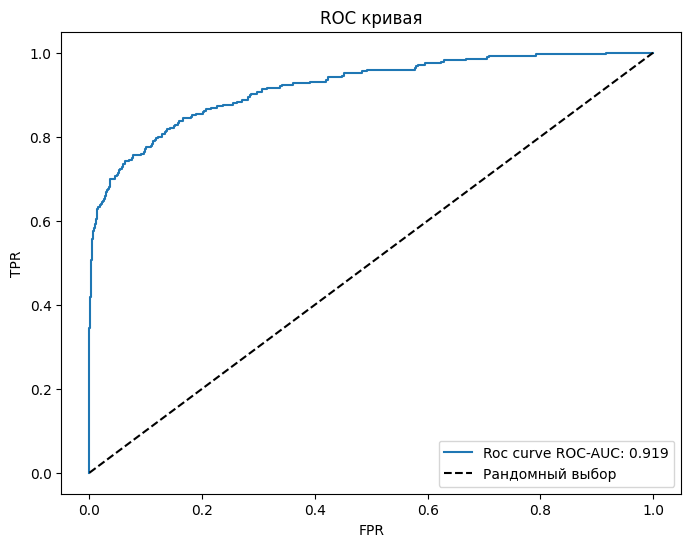

In [42]:
y_pred_proba = oscv_cb.best_estimator_.predict_proba(X_test)[:,1]

test_score = roc_auc_score(y_test_lbl, y_pred_proba)

print(f'Метрика roc-auc на тестовой выборке: {test_score:.3f}')

fpr, tpr, _ = roc_curve(y_test_lbl, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Roc curve ROC-AUC: {test_score:.3f}')
plt.plot([0,1],[0,1], 'k--', label='Рандомный выбор')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC кривая')
plt.legend(loc='lower right')
plt.show()

Можем увидеть изменение ROC кривой в зависимости от выбранного порога. Также на сколько предсказания лучше, если бы мы делали предсказания рандомно

Accuracy = 0.9273140261215219


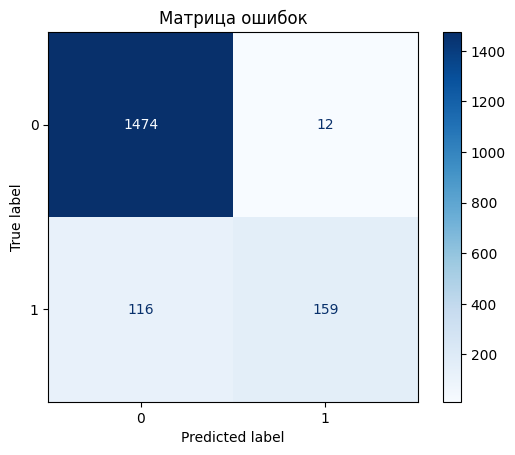

In [43]:
y_pred = oscv_cb.best_estimator_.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test_lbl, y_pred)}')

cm = confusion_matrix(y_test_lbl, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Матрица ошибок')
plt.show()

Модель делает минимальные ошибки первого рода, то есть практически не ошибается с тем, чтобы отнести клиента к тем, кто не уйдет.
Но с определением того, что клиент уйдет, судя по матрице, дела обстоят хуже.

In [44]:
pipe = oscv_cb.best_estimator_
tch_imp = pipe.named_steps['tch_imputer']
pre = pipe.named_steps['preprocessor']
cb_model = pipe.named_steps['models']

pre.set_output(transform='pandas')

X_test_changed = pre.transform(tch_imp.transform(X_test))
feature_names = list(X_test_changed.columns)
cat_after = X_test_changed.select_dtypes(exclude='number').columns.to_list()

test_pool = Pool(X_test_changed, y_test_lbl, cat_features=cat_after, feature_names=feature_names)

shap_values = cb_model.get_feature_importance(test_pool, type='ShapValues')
feature_shap = shap_values[:, :-1]

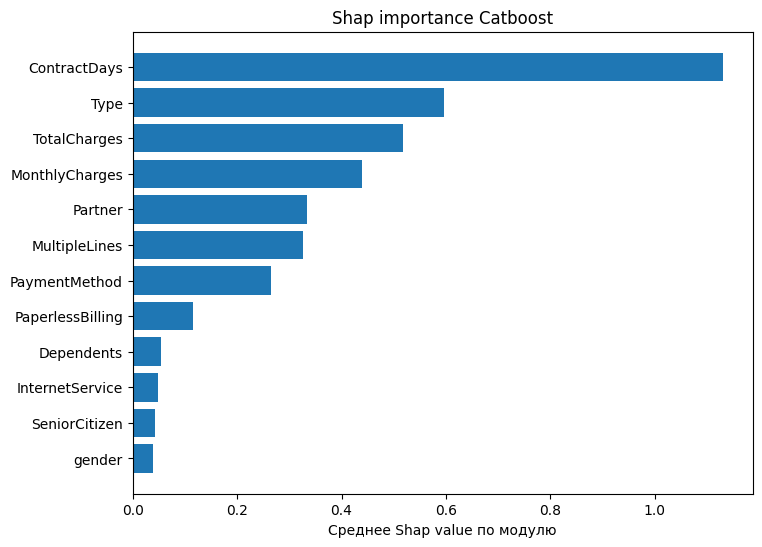

In [45]:
mean_abs = np.abs(feature_shap).mean(axis=0)
importance_df = pd.DataFrame({'feature': test_pool.get_feature_names(), 'mean_abs_shap': mean_abs}).sort_values('mean_abs_shap', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['feature'], importance_df['mean_abs_shap'])
plt.xlabel('Среднее Shap value по модулю')
plt.title('Shap importance Catboost')
plt.show()



Судя по графику, модель определелила следующие 4 наиболее важные фичи: число дней контракта, тип оплаты и расходы в целом и за месяц.

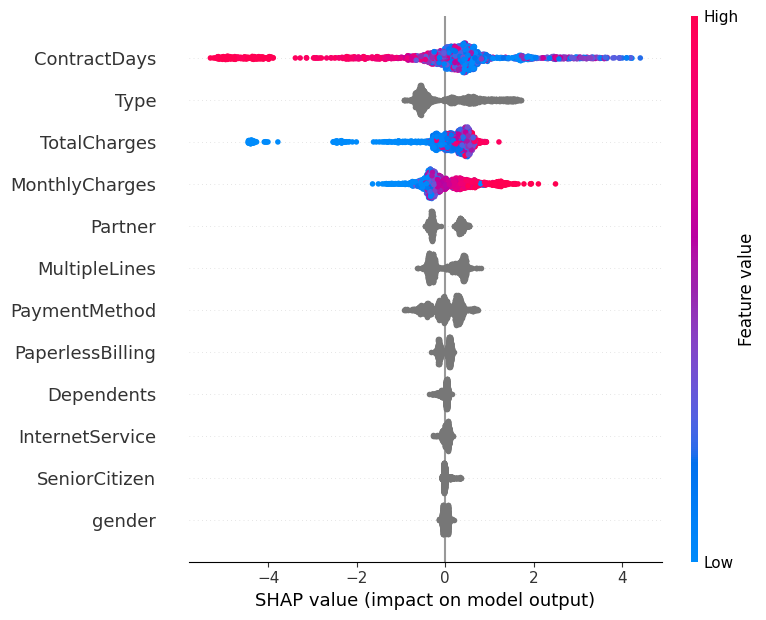

In [46]:
shap.summary_plot(
    feature_shap,
    features=X_test_changed,
    feature_names=feature_names,
    show=True
)

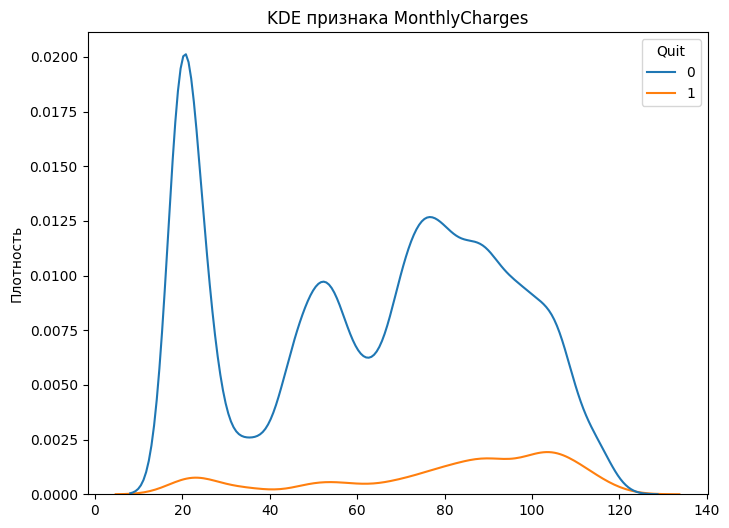

In [47]:
model_test_df = X_test_changed.copy()
model_test_df['Quit'] = y_pred

plt.figure(figsize=(8, 6))
sns.kdeplot(data=model_test_df, x='MonthlyCharges', hue='Quit', bw_adjust=0.5)
plt.title('KDE признака MonthlyCharges')
plt.ylabel('Плотность')
plt.xlabel('')
plt.show()

К сожелению, рассматривая график KDE, нельзя сделать вывод, что при уменьшении месячных расходов, клиенты склонны оставаться.

## Вывод

Была испешно найдена модель, удовлетворяющая нашим условиям. Пройдемся по всем этапам:
- предобработка и подготовка данных: добавлен новый признак, дней контракта. были удалены даты и избавились от мультиколениарности. пропуски в категориальных фичах заполнены 'other', в числовых средним;
- на этапе обучения лучше всего показала себя модель CatBoost с roc-auc равной 0.907;

In [48]:
models = pd.DataFrame({'models': ['LR', 'RandomForest', 'Catboost'], 'metrics': [f'{oscv_lr.best_score_:.3f}', f'{oscv_rfc.best_score_:.3f}', f'{oscv_cb.best_score_:.3f}']})
display(models)

,models,metrics
0,LR,0.767
1,RandomForest,0.831
2,Catboost,0.907


In [49]:
print(f'Параметры, отобранные после кроссвалидации: {oscv_cb.best_params_}')
print(f'ROC-AUC на тестовой выборке: {test_score:.3f}')

Параметры, отобранные после кроссвалидации: {'models__iterations': 495, 'models__learning_rate': 0.09800576921111297, 'models__depth': 4, 'models__l2_leaf_reg': 1, 'models__bagging_temperature': 1}
ROC-AUC на тестовой выборке: 0.919


- accuracy на тестовой выборке равна 0.927;
- наиболее важными признаки модель определила: кол-во дней контракта, тип оплаты и траты в месяц, и трат в целом.
- при данной настройке модель делает минимальные ошибки первого рода, что говорит о том, что модель практически не ошибается в том, что клиент хочет остаться. Но вот ошибки второго рода более значительны, модель не всегда улавливает когда клиент уйдет. В качестве рекомендации могу предложить изменять порог отношения вероятности к классу, чтобы минимизировать нужную ошибку.